In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import camb
from pixell import enmap, utils
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchcubicspline
from torch.utils.data import Dataset, DataLoader
import os
import glob
from tqdm.notebook import tqdm
import time

In [2]:
DATA_FOLDER = '/mnt/home/dheurtel/ceph/01_data/'

DATA_DIR = 'CMB_PS_DIAG_H_ombh2'

CKPT_FOLDER = '/mnt/home/dheurtel/ceph/02_checkpoints/SIGMA_EMULATOR'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### PS Emulator

Dataset

In [3]:
## Create a custom torch dataset that loads pairs of npy files (sample and theta) from a directory (Only for training)

class NpyDataset(Dataset):
    def __init__(self, root_dir, transform=None, split = 0.1, seed = 1337, train = True):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = glob.glob(os.path.join(self.root_dir, 'sample_*.npy'))
        self.thetas = glob.glob(os.path.join(self.root_dir, 'theta_*.npy'))
        self.samples.sort()
        self.thetas.sort()
        self.samples = self.samples[:630]
        self.thetas = self.thetas[:630]
        if train:
            np.random.seed(seed)
            np.random.shuffle(self.samples)
            np.random.seed(seed)
            np.random.shuffle(self.thetas)
            self.samples = self.samples[:int(len(self.samples)*(1-split))]
            self.thetas = self.thetas[:int(len(self.thetas)*(1-split))]
        else:
            np.random.seed(seed)
            np.random.shuffle(self.samples)
            np.random.seed(seed)
            np.random.shuffle(self.thetas)
            self.samples = self.samples[int(len(self.samples)*(1-split)):]
            self.thetas = self.thetas[int(len(self.thetas)*(1-split)):]
        self.length = len(self.samples)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        sample = torch.from_numpy(np.load(self.samples[idx], allow_pickle=True).astype(np.float32))
        theta = torch.from_numpy(np.load(self.thetas[idx], allow_pickle=True).astype(np.float32))
        theta = (theta - torch.tensor([70, 32e-3]))/torch.tensor([20,25e-3])
        if self.transform:
            sample = self.transform(sample)
            theta = self.transform(theta)
        return sample, theta

def rescale_theta(theta):
    return (theta - torch.tensor([70, 32e-3]).to(device))/torch.tensor([20,25e-3]).to(device)

def make_dataset(root_dir, transform=None, split = 0.1, seed = 1337):
    return NpyDataset(root_dir, transform, split, seed, True), NpyDataset(root_dir, transform, split, seed, False)

train_dataset, test_dataset = make_dataset(os.path.join(DATA_FOLDER, DATA_DIR))
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Emulator

In [4]:
## Create a simple MLP to emulate Sigma(theta)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_hidden_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_hidden_layers = n_hidden_layers

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for i in range(n_hidden_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        for i in range(self.n_hidden_layers + 1):
            x = self.layers[i](x)
            x = F.relu(x)
        x = self.layers[-1](x)
        return x

emulator = MLP(2, 100, 128, 2).to(device)

Training Loop

In [5]:
# optimizer = torch.optim.AdamW(emulator.parameters(), lr=0.01, weight_decay=0.01)
# scheduler = StepScheduler(optimizer, 50, 0.05, step_period=200)
# loss_fn = torch.nn.MSELoss()

# # Train the emulator
# num_epochs = 1000
# emulator.train()
# progress_bar = tqdm(range(num_epochs))
# running_mean_test_loss = 0.1
# for epoch in range(num_epochs):
#     train_loss = 0
#     for _, batch in enumerate(train_dataloader):
#         optimizer.zero_grad()
#         output = emulator(batch[1].to(device))
#         loss = loss_fn(output, batch[0].to(device))
#         loss.backward()
#         train_loss += loss.item()*len(batch[0])
#         optimizer.step()
#     train_loss /= len(train_dataset)
#     test_loss = 0
#     with torch.no_grad():
#         for _, batch in enumerate(test_dataloader):
#             output = emulator(batch[1].to(device))
#             loss = loss_fn(output, batch[0].to(device))
#             test_loss += loss.item()*len(batch[0])
#     scheduler.step()
#     test_loss /= len(test_dataset)
#     running_mean_test_loss = 0.9*running_mean_test_loss + 0.1*test_loss
#     progress_bar.set_description(f"Epoch {epoch+1} | Train loss: {train_loss:.6f}| Running mean test loss: {running_mean_test_loss:.6f}")
#     progress_bar.update(1)

Checkpointing

In [6]:
MODEL_ID = 'Emulator_H0_ombh2_1'

ckpt = torch.load(os.path.join(CKPT_FOLDER, MODEL_ID + '.pt'))

emulator.load_state_dict(ckpt['network'])

<All keys matched successfully>

Interpolation

In [7]:
wn = (256*np.fft.fftfreq(256, d=1.0)).reshape((256,) + (1,) * (2 - 1))
wn_iso = np.zeros((256,256))
for i in range(2):
    wn_iso += np.moveaxis(wn, 0, i) ** 2
wn_iso = np.sqrt(wn_iso)

indices = np.fft.fftshift(wn_iso).diagonal()[128:] ## The value of the wavenumbers along which we have the power spectrum diagonal

torch_indices = torch.tensor(indices).to(device)

torch_wn_iso = torch.tensor(wn_iso, dtype=torch.float32).to(device)

def get_sigma(theta):
    theta = rescale_theta(theta) ## Shape (batch_size, 2) (H0, ombh2) are the 2 cosmological parameters
    torch_diagonals = emulator(theta) ## Shape (batch_size, 128) (128 is the number of wavenumbers along which we have the power spectrum diagonal)
    torch_diagonals = torch_diagonals.reshape((128, -1)) ## Shape (128, batch_size) to be able to use torchcubicspline
    spline = torchcubicspline.NaturalCubicSpline(torchcubicspline.natural_cubic_spline_coeffs(torch_indices, torch_diagonals))
    return torch.moveaxis(spline.evaluate(torch_wn_iso), -1, 0)

def sample_theta(n_samples):
    #np.random.uniform(50, 90)
    #np.random.uniform(7.5e-3,56.7e-3)
    return torch.tensor([40, 49.2e-3])*torch.rand(n_samples, 2) + torch.tensor([50, 7.5e-3])

def sample_ps(n_samples):
    theta = sample_theta(n_samples).to(device)
    return get_sigma(theta)

In [35]:
mean_theta = torch.tensor([70, 32.1e-3])
mean_theta = torch.tensor([6.4213e+01, 1.5618e-02])
ps = get_sigma(mean_theta.to(device).reshape(1,-1))

In [10]:
for i in range(10):
    sample_ps(100)

begin = time.time()

for i in range(100):
    sample_ps(100)

end = time.time()

print('Time to sample 100 ps: ', (end - begin)/100)

Time to sample 100 ps:  0.014145822525024413


### True CMB PS

In [16]:
def patch_shape_and_wcs(Npix, res):
    ndegree_patch = res * Npix / 60
    print(f"Size of the patch in degrees: {ndegree_patch:.2f}")
    box = np.array([[-1, 1], [1, -1]]) * utils.degree * ndegree_patch / 2
    shape, wcs = enmap.geometry(pos=box, res=res*utils.arcmin, proj='car')
    return shape, wcs

In [ ]:
[6.4213e+01, 1.5618e-02]

In [29]:
pars = camb.CAMBparams()

fixed_cosmo = True
zero_r = False

Npix = 256    # Number of pixels
res = 8       # Size of a pixel, in arcminutes

shape_patch, wcs_patch = patch_shape_and_wcs(Npix, res)
shape = [3, shape_patch[0], shape_patch[1]]

H0 = 70
ombh2 = 32.1e-3
omch2 = np.random.normal(0.12, 0.0012) if not fixed_cosmo else 0.12
tau = np.random.normal(0.0544, 0.0073) if not fixed_cosmo else 0.0544
logas = np.random.normal(3.044, 0.014) if not fixed_cosmo else 3.044
As = np.exp(logas) / 1e10
ns = np.random.normal(0.9649, 0.0042) if not fixed_cosmo else 0.9649

# From Planck 2018 I. paper, see Sect. 5.3
mnu = np.random.uniform(0.06, 0.1) if not fixed_cosmo else 0.8

# Inspired from the upper limit of Planck 2018 I. paper
logr = np.random.uniform(-3, -1.494850021680094)
if not zero_r:
    r = 10**logr
else:
    r = 0

pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=0, tau=tau)
pars.InitPower.set_params(As=As, ns=ns, r=r)
pars.set_for_lmax(4000, lens_potential_accuracy=0)
pars.WantTensors = True

results = camb.get_results(pars)
cl_TT, cl_EE, cl_BB, cl_TE = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)['total'].T

comp = np.zeros((3, 3, cl_TT.shape[-1]))
comp[0,0] = cl_TT
comp[1,1] = cl_EE
comp[0,1] = cl_TE
comp[1,0] = cl_TE
comp[2,2] = cl_BB

ps_maps = enmap.spec2flat(shape, wcs_patch, enmap.massage_spectrum(comp, shape), 1, mode='constant')
true_ps = ps_maps[0,0]

Size of the patch in degrees: 34.13


In [30]:
def sym_mean(ps):
    return 1/4*(ps + np.rot90(ps, 2) + np.rot90(ps, 1) + np.rot90(ps, 3))

In [31]:
true_ps = np.fft.fftshift(true_ps)
true_ps[1:,1:] = sym_mean((true_ps)[1:,1:]) # symmetrize the PS

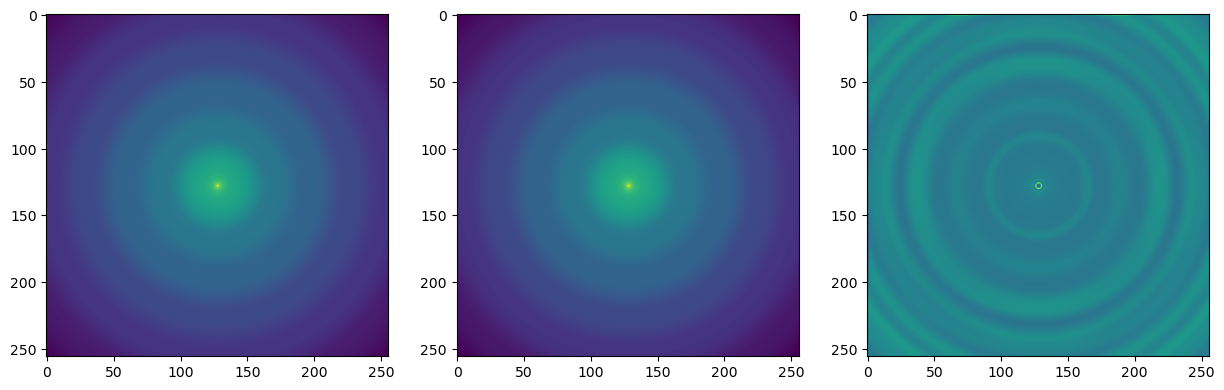

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.fft.fftshift(ps.detach().cpu().numpy()[0]), vmax = 18, vmin = 4)
ax[1].imshow((np.log(true_ps)))
ax[2].imshow((np.log(true_ps)) - np.fft.fftshift(ps.detach().cpu().numpy()[0]))

In [38]:
np.abs(((np.log(true_ps)) - np.fft.fftshift(ps.detach().cpu().numpy()[0]))/np.log(true_ps)).max()

0.009324837009483479

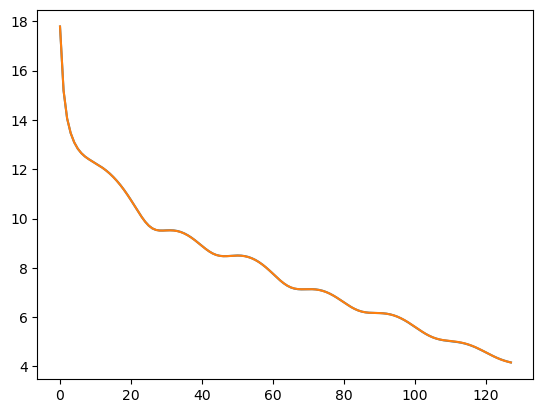

In [39]:
plt.plot((ps.detach().cpu().numpy()[0].diagonal())[:128])
plt.plot(np.log(np.fft.fftshift(true_ps)).diagonal()[:128])